In [1]:
from utils import *
from opt import *
from time import perf_counter
import pickle

from joblib import Parallel, delayed
import os

from sklearn.covariance import graphical_lasso

SEED = 10
SAVE = True
PATH = './results/min_eigv/'
N_CPUS = os.cpu_count()
np.random.seed(SEED)

os.environ["OMP_NUM_THREADS"] = str(N_CPUS)

## Auxiliary functions

In [8]:
def plot_results(x_range, err, exps, y_label='Error', plot_f='semilogx', plt_args={},
                 save=False, file_name=None, agg='mean'):

    mean_err = np.median(err, axis=0) if agg == 'median' else np.mean(err, axis=0)
    fig = plt.figure(figsize=(5,4))
    ax = fig.subplots()

    for i, exp in enumerate(exps):
        getattr(ax, plot_f)(x_range, mean_err[:,i], exp['fmt'], **plt_args, label=exp['leg'])

    ax.set_xlabel('PSD factor')
    ax.set_ylabel(y_label)
    ax.legend()
    ax.grid(True)
    fig.tight_layout()

    if save and file_name:
        plt.savefig(file_name)
        print('Fig save as:', file_name)
        
def save_files(prefix, sufix, data, frob_err, bias):
    graphs_file_name = f'{prefix}mineigv_graphs_{sufix}.pkl'
    with open(graphs_file_name, 'wb') as f:
        pickle.dump(data, f)
        print('GRAPHS SAVED AS:', graphs_file_name)
    
    perfs_file_name = f'{prefix}mineigv_perf_{sufix}'
    np.savez(perfs_file_name, frob_err=frob_err, f1_score=f1_score,
             sqrt_bias=bias)
    print('PERFORMANCE SAVED AS:', perfs_file_name)

    mean_frob_err = np.mean(frob_err, axis=0)
    mean_sqrt_bias = np.mean(bias, axis=0)
    err_bias_csv_file_name = f'{PATH}mineigv{sufix}_err_bias.csv'
    # error_bias_to_csv(err_bias_csv_file_name,  data['Exps'], mean_sqrt_bias, mean_frob_err)
    error_to_csv(err_bias_csv_file_name, data['Exps'], data['PSD_FACT'], mean_frob_err)

    mean_time = np.mean(data['runingtimes'], axis=0)
    time_csv_file_name = f'{PATH}mineigv{sufix}_time.csv'
    error_to_csv(time_csv_file_name, data['Exps'], data['PSD_FACT'], mean_time)
    print('BIAS CSV SAVED AS:', time_csv_file_name)


def compute_metric_err(Thetas_est, Thetas_true, n_exps, Zs=None, thr=.2, metric_type='err'):
    n_graphs = len(Thetas_est)
    n_samples = len(Thetas_est[0])

    metric = np.zeros((n_graphs, n_samples, n_exps))
    for i, Thetas in enumerate(Thetas_true):
        for j, Theta in enumerate(Thetas):
            p = Theta.shape[0]
            Theta_od = Theta*(1-np.eye(p))
            for k in range(n_exps):
            
                Theta_exps_od = Thetas_est[i][j][k]*(1-np.eye(p))

                if metric_type == 'err':
                    metric[i,j,k] = compute_frob_err(Theta_exps_od, Theta_od)
                elif metric_type == 'err-v2':
                    metric[i,j,k] = compute_frob_err(Theta_exps_od, Theta_od)
                elif metric_type == 'f1':
                    metric[i,j,k] = compute_f1_score(Theta_exps_od, Theta_od, thr)
                elif metric_type == 'bias':
                    mean_Theta = np.mean(mat2lowtri(np.abs(Theta_exps_od)))
                    metric[i,j,k] = compute_dp2(Theta_exps_od, Zs[i][j]) / mean_Theta if mean_Theta else 0
                elif metric_type == 'sqrt-bias':
                    mean_Theta = np.mean(mat2lowtri(np.abs(Theta_exps_od)))
                    metric[i,j,k] = np.sqrt(compute_dp2(Theta_exps_od, Zs[i][j])) / mean_Theta if mean_Theta else 0
                else:
                    raise ValueError('Unknown metric.')

    return metric

def create_Z(p, group_prop):
    assert np.sum(group_prop) == 1
    g = len(group_prop)
    nodes_per_group = [int(p*prop) for prop in group_prop]
    
    Z = np.zeros((g, p))
    cont = 0
    for i, n_nodes in enumerate(nodes_per_group):
        if i == g - 1:
            Z[i,cont:] = 1
        else:
            Z[i,cont:n_nodes+cont] = 1
            cont += n_nodes

    return Z

def create_data(p, n, mean_deg, group_prop, psd_fact=.05, weighted_edges=True, w_range=(.5, 1)):
    Z = create_Z(p, group_prop)

    # Create graph
    edge_prob = mean_deg/(p-1)
    A_true = generate_connected_er(p, edge_prob)

    if weighted_edges:
        weights = np.random.uniform(w_range[0], w_range[1], size=A_true.shape)
        weights = np.tril(weights)
        A_true = (weights + weights.T) * A_true

    # Precision matrix as loaded adjacency
    min_eigenval = la.eigvalsh(A_true)[0]
    Theta = (psd_fact - min_eigenval) * np.eye(p) + A_true

    # Create signals
    Sigma = la.pinv(Theta)
    X = np.random.multivariate_normal(np.zeros(p), Sigma, n)
    Sigma_hat = X.T@X/n

    return Sigma_hat, Theta, Z

def get_mu1_value(n_nodes, n_samples, times=1):
    return np.sqrt(np.log(n_nodes) / n_samples) * times 

def get_mu2_value(n_nodes, times=1):
    return times * (n_nodes - 1)**2

def get_n_samples(n_nodes, n_edges, times=1):
    return int((n_nodes + n_edges)*np.log(n_nodes) * times)

def run_exp(g, psd_fact, data_p, exps, verb=False):
    Thetas_true = []
    Thetas_est = []
    Zs = []
    runingtimes = np.zeros((len(psd_fact), len(exps)))
    for i, psd_fact in enumerate(psd_fact):
        if verb and g % N_CPUS == N_CPUS - 1:
            print('Graph', g+1, 'Load factor:', psd_fact)

        n = get_n_samples(data_p['p'], data_p['p']*data_p['mean_deg'])
        Sigma_hat, Theta, Z = create_data(n=n, psd_fact=psd_fact, **data_p)
        Thetas_true.append(Theta)
        Zs.append(Z)

        Theta_od = Theta*(1-np.eye(data_p['p']))

        Thetas_est_e = np.zeros((len(exps), data_p['p'] ,data_p['p']))
        for j, exp in enumerate(exps):
            args = exp['args'].copy()

            t_init = perf_counter()
            args['mu1'] = get_mu1_value(data_p['p'], n, args['mu1'] )
            args['mu2'] = get_mu2_value(data_p['p'], args['mu2'] ) 
            Theta_est = FairGLASSO_fista(Sigma_hat, Z=Z, **args)
            
            runingtimes[i,j] = perf_counter() - t_init
            Thetas_est_e[j] = Theta_est

            Theta_est_od = Theta_est*(1-np.eye(data_p['p']))
            err = compute_frob_err(Theta_est_od, Theta_od)
            bias = compute_dp2(Theta_est, Z) / np.mean(mat2lowtri(np.abs(Theta_est_od))) if np.mean(mat2lowtri(np.abs(Theta_est_od))) else 0
            bias_v2 = compute_dp2(Theta_est_od, Z) / np.mean(mat2lowtri(np.abs(Theta_est_od))) if np.mean(mat2lowtri(np.abs(Theta_est_od))) else 0

            if verb and g % N_CPUS == N_CPUS - 1:
                print(f'\t{exp["leg"]}: Err: {err:.4f} | Bias: {bias:.5f} | Bias v2: {bias_v2:.5f} | Time: {runingtimes[i,j]:.4f}')

        Thetas_est.append(Thetas_est_e)
        
    return Thetas_est, Thetas_true, runingtimes, Zs

## Experiment 1 - Swept on Mu2

In [3]:
# Experiment params
num_trials =  50

# Graph parameters
data_p = {
    'p': 100,
    'mean_deg': 5,
    'weighted_edges': True,
    'w_range': (.5, 1),
    # 'psd_fact': .1,
    'group_prop': [.5, .5],
}

PSD_FACT = [1, .1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-8, 1e-12] # [1, .1, 1e-2, 1e-3, 1e-4, 0]
num_params = len(PSD_FACT)
verbose = True

In [4]:
PREC_TYPE = None

Exps = [
    {'model': 'fair_flasso', 'args': {'mu1': .1, 'eta': 2e-3, 'mu2': 10, 'epsilon': 1, 'bias_type': 'dp', 
     'prec_type': PREC_TYPE, 'EARLY_STOP': True}, 'fmt': 'o-', 'leg': 'FGL-1'},

    {'model': 'fair_flasso', 'args': {'mu1': .1, 'eta': 1e-3, 'mu2': 10, 'epsilon': .5, 'bias_type': 'dp', 
     'prec_type': PREC_TYPE, 'EARLY_STOP': True}, 'fmt': 'o-', 'leg': 'FGL-0.5'},
    
    {'model': 'fair_flasso', 'args': {'mu1': .1, 'eta': 5e-3, 'mu2': 10, 'epsilon': .1, 'bias_type': 'dp', 
     'prec_type': PREC_TYPE, 'EARLY_STOP': True}, 'fmt': 'o-', 'leg': 'FGL-0.1'},

    {'model': 'fair_flasso', 'args': {'mu1': .1, 'eta': 1e-3, 'mu2': 10, 'epsilon': .05, 'bias_type': 'dp', 
     'prec_type': PREC_TYPE, 'EARLY_STOP': True}, 'fmt': 'o-', 'leg': 'FGL-0.05'},
]

print('CPUs employed:', N_CPUS)
t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_exp)
                                  (g, PSD_FACT, data_p, Exps, verb=verbose) for g in range(num_trials))
ellapsed_t = (perf_counter()-t_init)/60
print(f'----- Solved in {ellapsed_t:.3f} minutes -----')


Thetas_est, Thetas_true, runingtimes, Zs = zip(*results)

CPUs employed: 64


/tmp/ipykernel_10587/1980979053.py:107: RuntimeWarning: covariance is not symmetric positive-semidefinite.
/tmp/ipykernel_10587/1980979053.py:107: RuntimeWarning: covariance is not symmetric positive-semidefinite.


----- Solved in 1.162 minutes -----


In [9]:
frob_err = compute_metric_err(Thetas_est, Thetas_true, len(Exps), Zs=None, thr=.2, metric_type='err-v2')
sqrt_bias = compute_metric_err(Thetas_est, Thetas_true, len(Exps), Zs=Zs, thr=.2, metric_type='sqrt-bias')

if SAVE:
    data = {
        'Exps': Exps,
        'PSD_FACT': PSD_FACT,
        'Thetas_est': Thetas_est, 
        'Thetas_true': Thetas_true,
        'runingtimes': runingtimes,
        'Zs': Zs,
    }
    save_files(PATH, 'mu2vals', data, frob_err, sqrt_bias)

GRAPHS SAVED AS: ./results/min_eigv/mineigv_graphs_mu2vals.pkl
PERFORMANCE SAVED AS: ./results/min_eigv/mineigv_perf_mu2vals
SAVED as: ./results/min_eigv/mineigvmu2vals_err_bias.csv


UnboundLocalError: local variable 'time_csv_file_name' referenced before assignment

Fig save as: ./results/min_eigv/mineigv_mu2vals_plt_err
Fig save as: ./results/min_eigv/mineigv_mu2vals_plt_err_med
Fig save as: ./results/min_eigv/mineigv_mu2vals_plt_sqrtbias


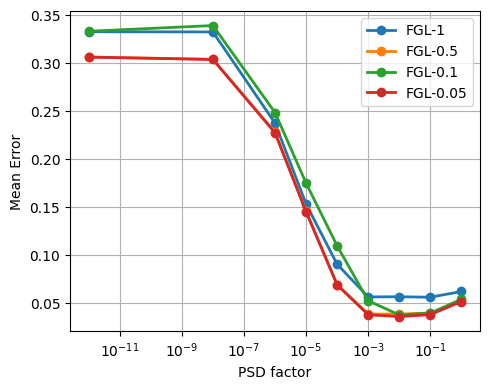

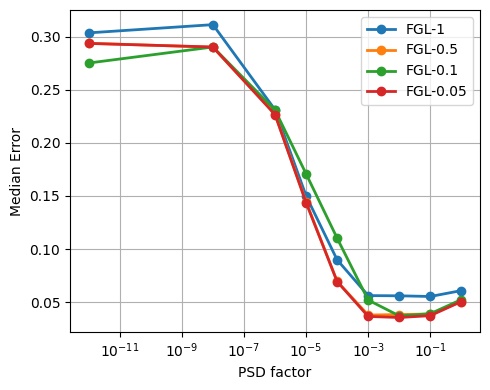

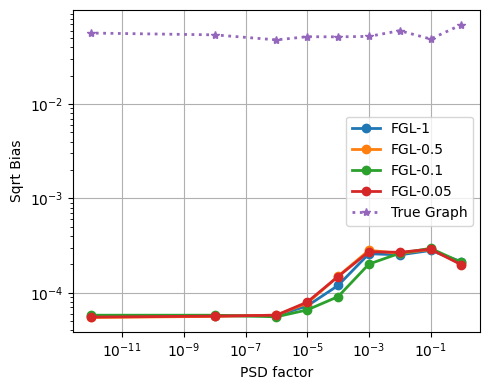

In [6]:
# Including bias from true graph
true_bias = compute_metric_err(Thetas_true, Thetas_true, 1, Zs=Zs, thr=.2, metric_type='bias')
true_sqrt_bias = compute_metric_err(Thetas_true, Thetas_true, 1, Zs=Zs, thr=.2, metric_type='sqrt-bias')
true_exp = {'fmt': '*:', 'leg': 'True Graph'}
Exps_aux =  Exps + [true_exp]
sqrt_bias_aux = np.concatenate((sqrt_bias, true_bias), axis=2)

plt_args = { 'linewidth': 2 }
plot_results(PSD_FACT, frob_err, Exps, y_label='Mean Error', plt_args=plt_args, save=SAVE,
             file_name=f'{PATH}mineigv_mu2vals_plt_err')
plot_results(PSD_FACT, frob_err, Exps, y_label='Median Error', plt_args=plt_args, save=SAVE,
             file_name=f'{PATH}mineigv_mu2vals_plt_err_med', agg='median')
plot_results(PSD_FACT, sqrt_bias_aux, Exps_aux, y_label='Sqrt Bias', plt_args=plt_args, plot_f='loglog', 
             save=SAVE, file_name=f'{PATH}mineigv_mu2vals_plt_sqrtbias')



Fig save as: ./results/min_eigv/mineigv_mu2vals_plt_err
Fig save as: ./results/min_eigv/mineigv_mu2vals_plt_err_med
Fig save as: ./results/min_eigv/mineigv_mu2vals_plt_sqrtbias


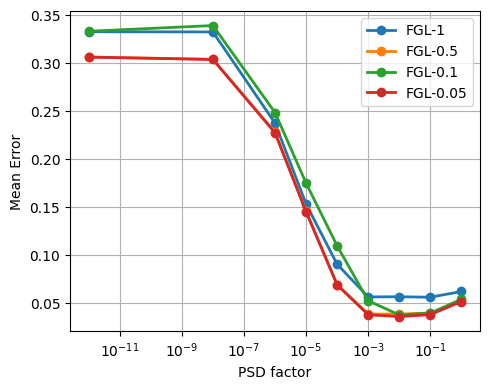

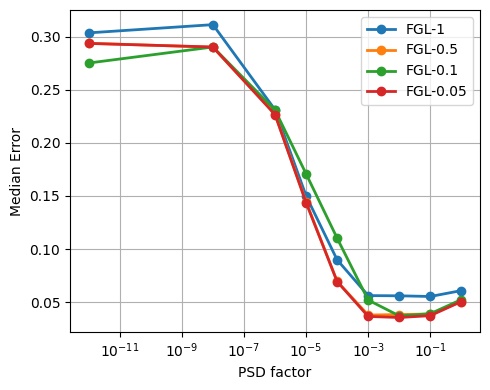

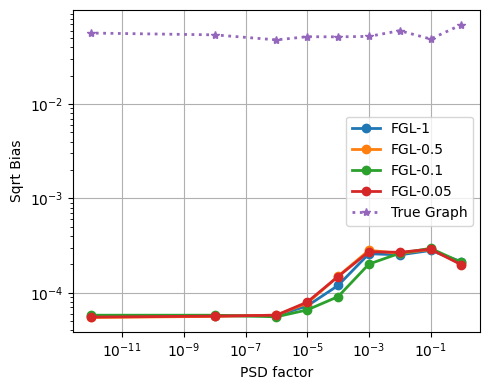

In [7]:
# Including bias from true graph
true_bias = compute_metric_err(Thetas_true, Thetas_true, 1, Zs=Zs, thr=.2, metric_type='bias')
true_sqrt_bias = compute_metric_err(Thetas_true, Thetas_true, 1, Zs=Zs, thr=.2, metric_type='sqrt-bias')
true_exp = {'fmt': '*:', 'leg': 'True Graph'}
Exps_aux =  Exps + [true_exp]
sqrt_bias_aux = np.concatenate((sqrt_bias, true_bias), axis=2)

plt_args = { 'linewidth': 2 }
plot_results(PSD_FACT, frob_err, Exps, y_label='Mean Error', plt_args=plt_args, save=SAVE,
             file_name=f'{PATH}mineigv_mu2vals_plt_err')
plot_results(PSD_FACT, frob_err, Exps, y_label='Median Error', plt_args=plt_args, save=SAVE,
             file_name=f'{PATH}mineigv_mu2vals_plt_err_med', agg='median')
plot_results(PSD_FACT, sqrt_bias_aux, Exps_aux, y_label='Sqrt Bias', plt_args=plt_args, plot_f='loglog', 
             save=SAVE, file_name=f'{PATH}mineigv_mu2vals_plt_sqrtbias')

